# **Task \#4 A**: Machine Learning MC886/MO444
##**Convolution Models and Transfer Learning**##

In [1]:
print('Marcelo Antunes Soares Fantini' + ' RA 108341')
print('Rubens de Castro Pereira' + ' RA 217146')

Marcelo Antunes Soares Fantini RA 108341
Rubens de Castro Pereira RA 217146


## Objective:

The objective of this project is to implement alternative approaches to **Convolutional Neural Networks** (CNNs) and **Transfer Learning Techniques** in order to devise the most effective model for addressing the given problems.

**Obs: In this work, you can use scikit-learn and PyTorch.**

## Dataset

The COCO (Common Objects in Context) dataset is a widely used benchmark dataset in computer vision research. It serves as a valuable resource for various tasks including object recognition, segmentation, and captioning. The dataset comprises a vast collection of images, each meticulously annotated with detailed information about the objects present in the image. It covers a diverse range of object categories, encompassing everyday objects such as people, animals, vehicles, and household items.

Dataset Information:

- The dataset consists of approximately 115,000 images. However, for your convenience, you can work with a subset that contains at least 30,000 images. You can utilize the function get_partial_dataset to create this partial dataset.

- The following code cell will download the dataset, but please note that if the runtime gets disconnected, you will need to download it again. In case the authorization key doesn't work, you can download the dataset from the links provided below.

- The data is available at: ([Link of the Dataset](https://drive.google.com/drive/folders/12dZ4lkKkAZ6CKcvDtwzXSLrYOy_avWW8?usp=sharing)): ```Multiclass Classfication``` and ```COCO JSON```


More information about the dataset: *Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." Computer Vision–ECCV 2014: 13th European Conference, Zurich, Switzerland, September 6-12, 2014, Proceedings, Part V 13. Springer International Publishing, 2014.*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%time
!tar -xf drive/MyDrive/COCO-Dataset/coco-multiclass.tar.gz
!tar -xf drive/MyDrive/COCO-Dataset/coco-object-detection.tar.gz

tar: drive/MyDrive/COCO-Dataset/coco-multiclass.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
tar: drive/MyDrive/COCO-Dataset/coco-object-detection.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
CPU times: user 6.99 ms, sys: 2.98 ms, total: 9.97 ms
Wall time: 209 ms


## Libraries

In [ ]:
import os
import cv2
import json
import torch
import numpy as np
import glob as glob
import pandas as pd
import torch.nn as nn
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from torchvision import models
from tqdm.notebook import tqdm
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import Resize, Compose, ToTensor
from torch.utils.data import Dataset, DataLoader

## Classification Task with COCO

In the COCO dataset, each sample can have multiple labels. Therefore, using the CrossEntropy loss function, which relies on softmax activation, is not suitable for the multi-label classification problem. Let's explore why CrossEntropy is not appropriate in this case.

![loss_definition_1](https://drive.google.com/uc?export=view&id=1BDkR2n6aNq6VvXnQNYw7dxtzfveijysB)

The above image illustrates how we calculate the CrossEntropy loss in a simple multi-class classification scenario, where the target labels are mutually exclusive. The loss computation focuses on the logit corresponding to the true target label and its relative magnitude compared to other labels. However, softmax ensures that all predicted probabilities sum to 1, making it impossible to have several correct answers.

![loss_definition_2](https://drive.google.com/uc?export=view&id=1tMQ0WFY1HAIlBnp3bSVic4gy1GJuJyc4)

To address this, we need to treat each prediction independently. One solution is to use the Sigmoid function as a normalizer for each logit value individually. This way, we can have multiple correct labels and their respective predicted probabilities for each label. We can then compare these probabilities with the probabilities of the correct labels (set to 1) using the BinaryCrossEntropy loss.

![loss_definition_3](https://drive.google.com/uc?export=view&id=1Mp5lo3EFEM7vMNE_5TM-Zts1NgY8oTrn)

Hence, the appropriate solution is to use the BinaryCrossEntropy loss.

**Consequently, models should have sigmoid as the last activation function to handle multi-label classification tasks correctly.**

In [ ]:
## ----- Global Variables ----- ##
batch_size      = None
learning_rate   = None
epochs          = None
evaluate_period = None

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cpu


### Auxiliar functions


In [ ]:
def get_partial_dataset(path, save_filename='partial_dataset', n_samples=30000):
  '''
    Creates a partial dataset for training

    Parameters
    ----------
    path : str
      Path to the _classes.csv file.

    save_filename : str
      Name of the file to be saved.

    n_samples : int
      Specifies the number of samples for training.
  '''

  df = pd.read_csv(path)
  idxs = []

  # --- Remove samples without class labels --- #
  for i, row in df.iterrows():
      if row[1:].sum() == 0:
          idxs.append(i)

  df.drop(idxs, inplace=True)

  # --- Randomly remove samples --- #
  idxs = df.sample(df.shape[0] - n_samples).index
  df   = df.drop(idxs).reset_index(drop=True)

  # --- Save locally --- #
  # Include the Google Drive path to ensure the preservation of this information!
  df.to_csv(f'{save_filename}.csv', index=False)

get_partial_dataset('COCO-multiclass/train/full_dataset.csv')

### Class Dataset and DataLoader

*Obs: Learn more in [Dataset and Dataloader Tutorial Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)*

In [ ]:
class COCOMulticlass(Dataset):
  '''
    Dataset class

    Parameters:
    -----------
    __init__():
      annotations_file : str
        Path to the _classes.csv file or partial_dataset.csv file

      img_dir : str
        Path to the directory containing the images

      transform : torchvision.transforms
        Image transformations from the torchvision library.
  '''

  def __init__(self, annotations_file, img_dir, transform=None):
      self.img_labels = pd.read_csv(annotations_file)
      self.img_dir    = img_dir
      self.transform  = transform
      self.classes_names = self.img_labels.columns[1:]

  def __len__(self):
      return len(self.img_labels)

  def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
      image    = Image.open(img_path)
      label    = torch.Tensor(self.img_labels.iloc[idx, 1:].values.astype(float))

      if self.transform:
          image = self.transform(image)

      return image, label

In [ ]:
# --- Image transformations --- #
data_transform = Compose([Resize((224,224)), ToTensor()])

# --- Datasets --- #
train_dataset = COCOMulticlass('COCO-multiclass/train/partial_dataset.csv', 'COCO-multiclass/train', transform=data_transform)
valid_dataset = COCOMulticlass('COCO-multiclass/valid/_classes.csv', 'COCO-multiclass/valid', transform=data_transform)

# --- DataLoaders --- #
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# --- Classes --- #
class_names = train_dataset.classes_names

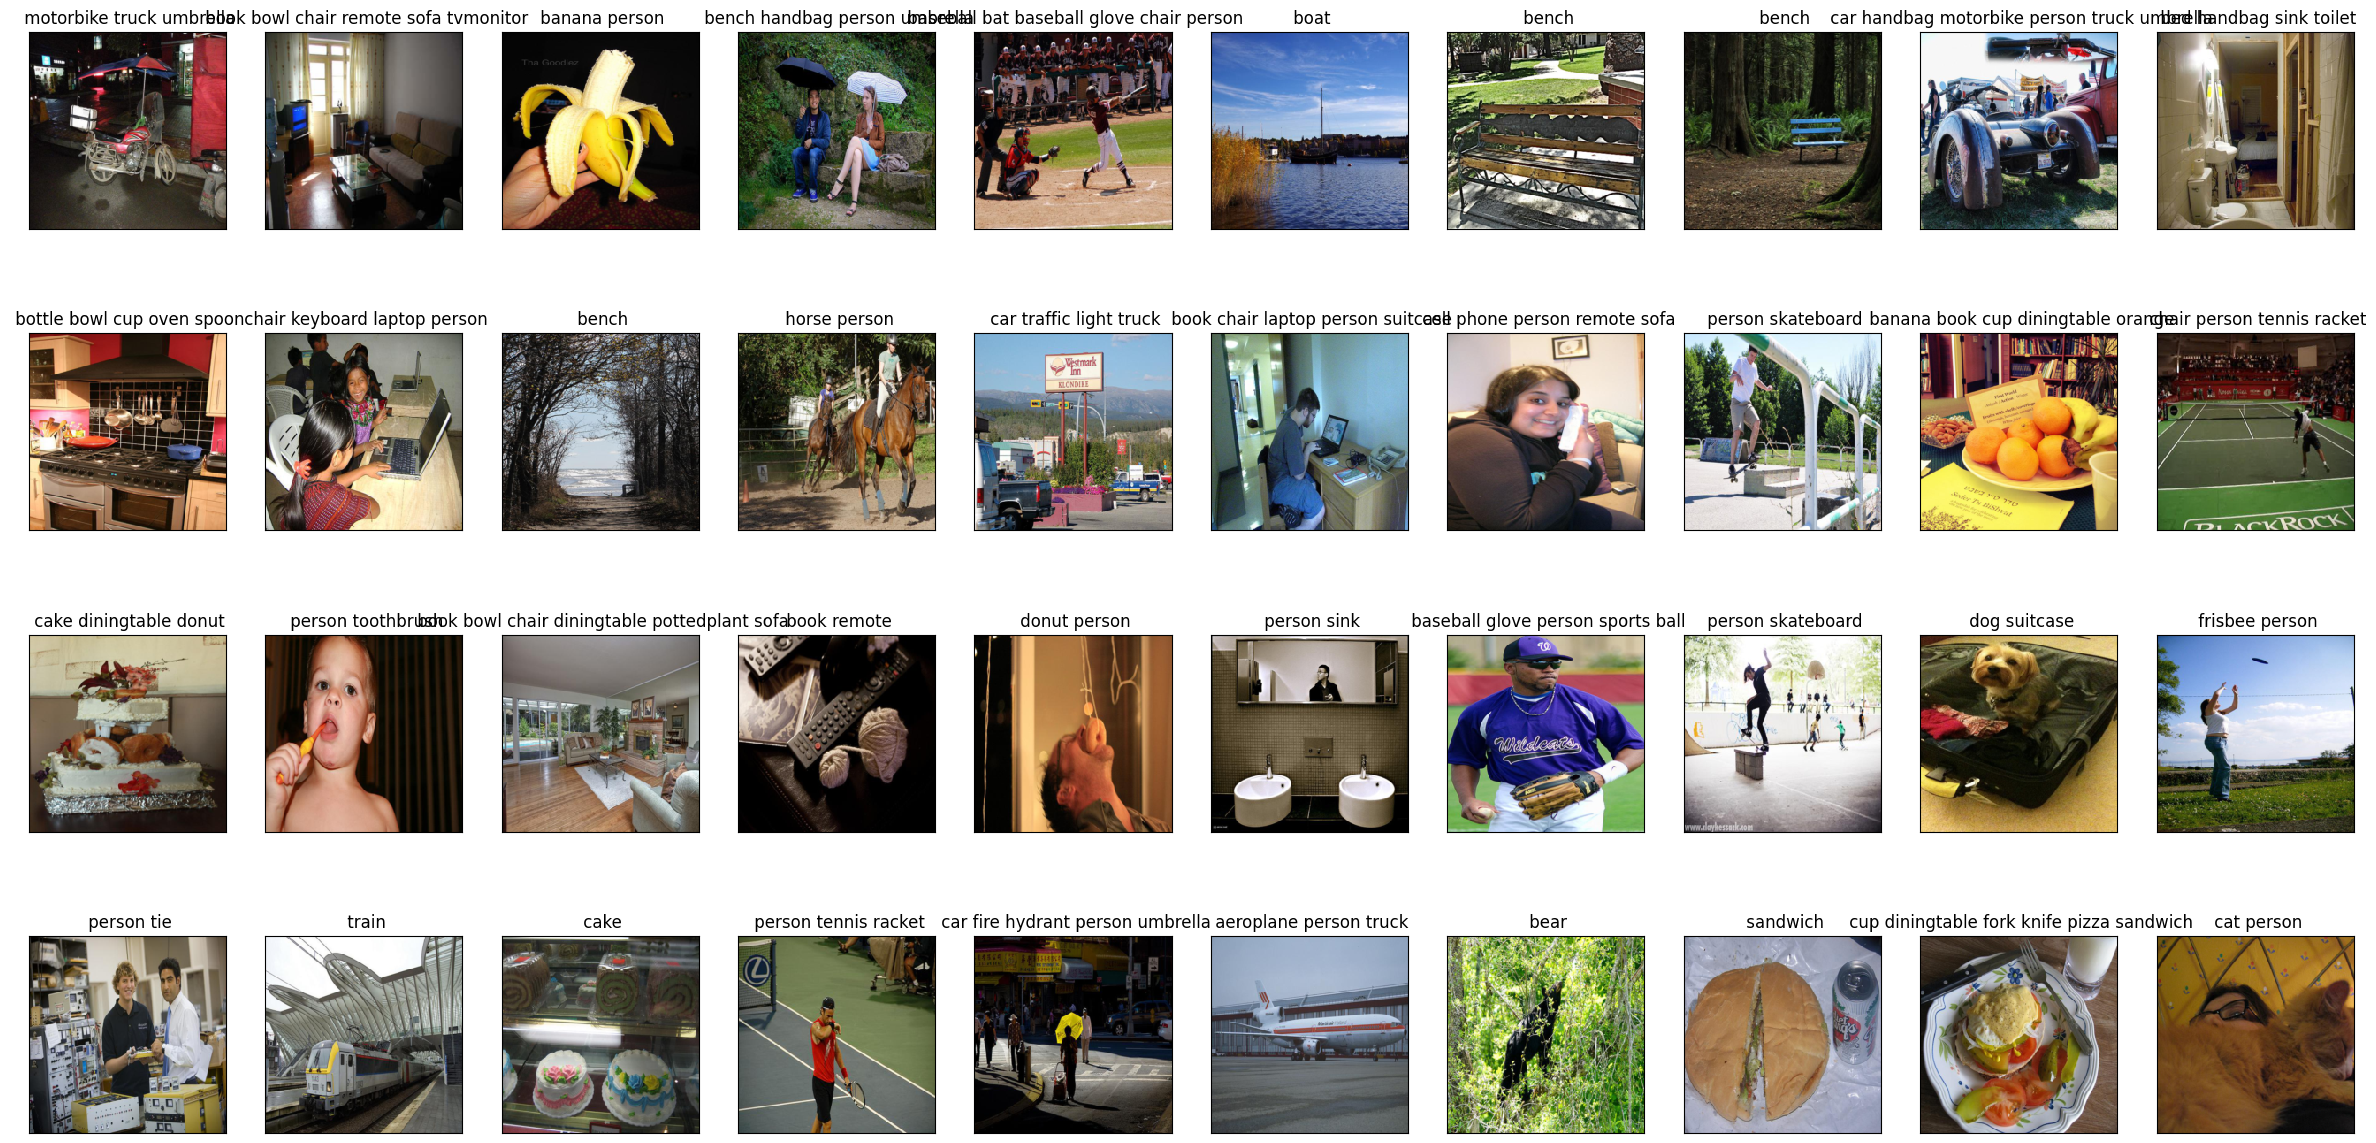

In [ ]:
## ------ Plot Data ----- ##
fig, axes = plt.subplots(4, 10, figsize=(30,15), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    data, target = train_dataset.__getitem__(i*10)
    ax.imshow(data.permute(1,2,0), cmap='binary', interpolation='nearest')
    ax.set_title(''.join(class_names[target == 1]))

### Train and Evaluate functions

In [ ]:
def train_one_epoch():
  '''
    Simple training function.

    Parameters:
    -----------
  '''

  # --- Insert Code Here --- #
  return None


def evaluate_one_epoch():
  '''
    Simple evaluation function.
  '''
  calculate_metrics()
  # --- Insert Code Here --- #
  return None

def save_model(model, best_loss, current_loss):
  '''
    Save the best model weights.
    This function saves the weights locally.
    To prevent data loss, consider adding the Google Drive path in the `torch.save()` function.

    Parameters:
    -----------
    model : nn.Module
      Model to save the weights.

    best_loss : float
      Best loss achieved so far.

    current_loss : float
      Current loss to compare with the best loss.
  '''
  if best_loss == None:
    best_loss = current_loss
    torch.save(model.state_dict(), 'weights.pth')

  elif best_loss > current_loss:
    best_loss = current_loss
    torch.save(model.state_dict(), 'weights.pth')

  else: pass
  return best_loss

def load_model(path, model):
  '''
    Load the model weights.

    Parameters:
    -----------
    path : str
      Path to the .pth file containing the weights.

    model : nn.Module
      Model to load the weights into.
  '''
  model.load_state_dict(torch.load(path))
  return model

In [ ]:
# TODO: Implement the appropriate metrics for the classification task
def calculate_metrics(target, pred, threshold=0.5):

    # --- Insert Code Here --- #
    return {'metric_1': None,
            'metric_2': None,
            ...
            'metric_n': None
            }

### 1. (3 points) Buil and train a Convolutional Neural Network (CNN) for Multi-Label Image Classification.

*Tip 1: Apply a weight regularization to avoid overfitting and improve the performance of the CNN (for example, l1, l2, l1 and l2).*

*Tip 2: Remember to use regularization layers, such as Dropout, BatchNorm and LayerNorm.*

In [ ]:
## TODO: Implement at least two convolutional neural networks
class HandcraftCNN_v1(nn.Module):
    def __init__(self):
        super(HandcraftCNN_v1, self).__init__()
        # --- Insert Code Here --- #

    def forward(self, x):
        # --- Insert Code Here --- #
        return None

class HandcraftCNN_v2(nn.Module):
    def __init__(self):
        super(HandcraftCNN_v2, self).__init__()
        # --- Insert Code Here --- #

    def forward(self, x):
        # --- Insert Code Here --- #
        return None

model_v1 = HandcraftCNN_v1()
model_v2 = HandcraftCNN_v2()

In [ ]:
data, target = next(iter(train_loader))
logits = model_v1(data.type(torch.float))

assert logits.shape == (batch_size, len(class_names)), 'The output shape is incorrect.'

In [ ]:
criterion     = nn.BCELoss()
optimizer     = None  # Choose an appropriate optimizer in https://pytorch.org/docs/stable/optim.html

model_v1.to(device)

best_loss = None

for epoch in range(0, epochs):
  # --- Train Model --- #
  train_one_epoch()

  # --- Evaluate model in N epochs --- #
  if (epoch % evaluate_period) == 0:
    evaluate_one_epoch()

    # --- Save best model weights --- #
    best_loss = save_model(model_v1, best_loss, np.array(history['valid'])[-1].mean())

    print(f"Epoch: {epoch}\n\tMetric_1 = {results['metric_1']}\tMetric_2 = {results['metric_2']}...\tMetric_N = {results['metric_n']}")

In [ ]:
## ----- Plot the Train and Valid loss ----- ##
fig, ax = plt.subplots(1, 4, figsize=(20,7))
plt.show()

### Visualize model predictions

In [ ]:
def show_prediction(model, dataloader, class_names):
  '''
  Show a sample prediction.

  Parameters:
  -----------
  model : nn.Module
    Model to be evaluated.

  dataloader : dataloader
    DataLoader for the example.

  class_names : list
    List containing the class names.

  '''
  data, target = next(iter(dataloader))
  data = data.to(device)
  logits = model(data.type(torch.float))
  pred   = np.array(logits.cpu() > .5, dtype=float)
  plt.imshow(data[0].cpu().permute(1,2,0))
  plt.axis('off')
  plt.show()

  target = ''.join(class_names[target[0] == 1])
  pred   = ''.join(class_names[pred[0] == 1])
  print(f"Target: {target}\nPred: {pred if len(pred) != 0 else 'NONE'}")

In [ ]:
model_v1 = HandcraftCNN_v1()
model_v1 = load_model()
model_v1.to(device).eval()

show_prediction(model_v1, valid_loader, class_names)

 > What are the conclusions? Was this model sufficient for the task? Do the hyperparameters, such as learning rate, batch size, and others, impact the final result? (1-2 paragraphs)

### 2. (3 points) Apply the Transfer Learning Technique by utilizing one of the pre-trained CNN models available in PyTorch as backbone.

In [ ]:
## TODO: Load a pre-trained convolutional model and fine-tune it on the COCO dataset
# Link: https://pytorch.org/vision/stable/models.html

class TransferLearningModel(nn.Module):
    def __init__(self):
        super().__init__()
        # --- Insert Code Here --- #
    def forward(self, x):
        # --- Insert Code Here --- #
        return None

model_tf = TransferLearningModel()

In [ ]:
data, target = next(iter(train_loader))
logits = model_tf(data.type(torch.float))

assert logits.shape == (batch_size, len(class_names)), 'Output Shape incorrect'

In [ ]:
criterion     = nn.BCELoss()
optimizer     = None  # Choose an appropriate optimizer in https://pytorch.org/docs/stable/optim.html

model_ft.to(device)

best_loss = None

for epoch in range(0, epochs):
  # --- Train Model --- #
  train_one_epoch()

  # --- Evaluate model in N epochs --- #
  if (epoch % evaluate_period) == 0:
    evaluate_one_epoch()

    # --- Save best model weights --- #
    best_loss = save_model(model_ft, best_loss, np.array(history['valid'])[-1].mean())

    print(f"Epoch: {epoch}\n\tMetric_1 = {results['metric_1']}\tMetric_2 = {results['metric_2']}...\tMetric_N = {results['metric_n']}")

In [ ]:
## ----- Plot the Train and Valid loss ----- ##
fig, ax = plt.subplots(1, 4, figsize=(20,7))
plt.show()

### Visualize model predictions

In [ ]:
model_tf = TransferLearningModel()
model_tf = load_model()
model_tf.to(device).eval()

show_prediction(model_tf, valid_loader, class_names)

 > What are the conclusions? Does the performance improve? Is it better to freeze the entire model or update all the weights in this case? (1-2 paragraphs)

### 3. (3 points) Apply the Data Augmentation technique to either the handcrafted model or the transfer learning model.

*Tip: Be careful to choose appropriate transformations that do not destroy the information of the sample.*

In [ ]:
## TODO: Implement data augmentation during training. Choose appropriate transformations.
# Link: https://pytorch.org/vision/stable/transforms.html

train_transforms = None
valid_transforms = None

train_dataset = COCOMulticlass('train/partial_dataset.csv', 'train', transform=train_transforms)
valid_dataset = COCOMulticlass('valid/_classes.csv', 'valid', transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
criterion     = nn.BCELoss()
optimizer     = None  # Choose an appropriate optimizer in https://pytorch.org/docs/stable/optim.html

model.to(device)

best_loss = None

for epoch in range(0, epochs):
  # --- Train Model --- #
  train()

  # --- Evaluate model in N epochs --- #
  if (epoch % evaluate_period) == 0:
    evaluate()

    # --- Save best model weights --- #
    best_loss = save_model(model, best_loss, np.array(history['valid'])[-1].mean())

    print(f"Epoch: {epoch}\n\tMetric_1 = {results['metric_1']}\tMetric_2 = {results['metric_2']}...\tMetric_N = {results['metric_n']}")

 > What are the conclusions? Does the performance improve? (1-2 paragraphs)

## Object Detection with COCO

Object detection is a fundamental computer vision task in deep learning that involves the identification and localization of objects within images or videos. It surpasses simple image classification, which only determines the presence or absence of specific objects in an image. Object detection algorithms not only recognize various objects but also provide valuable information about their locations using bounding box coordinates.

![object_example](https://drive.google.com/uc?export=view&id=1aFGdmMu4OzGfKjNjxdZXRu2wdz1JbJxC)


The goal of object detection is to accurately detect and classify multiple objects of different classes within an image. This task is challenging because objects can vary in size, shape, orientation, and occlusion. Additionally, there can be multiple instances of the same object class present in an image.

Deep learning-based object detection approaches typically involve training a neural network model to learn representations of objects. These models often use convolutional neural networks (CNNs) as the backbone architecture, which excel at learning hierarchical features from visual data. The most popular and effective deep learning models for object detection include Faster R-CNN, YOLO (You Only Look Once), and SSD (Single Shot MultiBox Detector).

![model_example](https://drive.google.com/uc?export=view&id=1Bov_GML9BfXoCtHzuQDYbiccj-3Ir0Mb)

During training, object detection models are typically trained on labeled datasets, where each annotated image contains bounding box annotations and corresponding class labels for the objects of interest. The models learn to predict the class labels and bounding box coordinates during the training process, optimizing their parameters through techniques like gradient descent and backpropagation.

In [ ]:
## ----- Global Variables ----- ##
batch_size      = None
learning_rate   = None
epochs          = None
evaluate_period = None

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

### Auxiliar functions

In [ ]:
def adjust_annotations(path, save_filename='_classes.csv'):
  '''
    Convert the json file to csv

    Parameters
    ----------
    path : str
      Path to the _annotations.coco.json file.

    save_filename : str
      Name of the file to be saved.
  '''

  data = json.load(open(path))

  df = open(save_filename, 'w')
  df.write('ImageID,Label,start_x,start_y,width,height,area,iscrowd\n')

  for a in data['annotations']:
    df.write(f"{a['image_id']},{a['category_id']},{a['bbox'][0]},{a['bbox'][1]},{a['bbox'][2]},{a['bbox'][3]},{a['area']},{a['iscrowd']}\n")

  df.close()

def get_partial_dataset(path, save_filename='partial_dataset', n_samples=30000):
  '''
    Creates a partial dataset for training

    Parameters
    ----------
    path : str
      Path to the _classes.csv file.

    save_filename : str
      Name of the file to be saved.

    n_samples : int
      Specifies the number of samples for training.
  '''

  df = pd.read_csv(path)

  idxs = df.ImageID.drop_duplicates()
  idxs = idxs.sample(idxs.shape[0] - n_samples).values.tolist()
  df = df.query('ImageID != @idxs').reset_index(drop=True)

  df.to_csv(f'{save_filename}.csv', index=False)

adjust_annotations('COCO-object-detection/train/_annotations.coco.json', '_classes_train.csv')
adjust_annotations('COCO-object-detection/valid/_annotations.coco.json', '_classes_valid.csv')
get_partial_dataset('_classes.csv')

### Class Dataset and DataLoader

*Obs: Learn more in [Dataset and Dataloader Tutorial Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)*

In [ ]:
class COCOObjectDetection(Dataset):
  '''
    Dataset class

    Parameters:
    -----------
    __init__():
      annotations_file : str
        Path to the _classes_train.csv file or partial_dataset.csv file

      img_idx_file : str
        Path to the _annotations.coco.json file.

      img_dir : str
        Path to the directory containing the images

      transform : torchvision.transforms
        Image transformations from the torchvision library.
  '''

  def __init__(self, annotations_file, img_idx_file, img_dir, transform=None):
    self.annotations = pd.read_csv(annotations_file)
    self.all_imgs    = self.annotations.ImageID.unique()
    self.img_dir     = img_dir
    self.img_id      = json.load(open(img_idx_file))['images']
    self.transform   = transform
    self.class_names = json.load(open(img_idx_file))['categories']

  def __len__(self):
    return len(self.all_imgs)

  def __getitem__(self, idx):
    image_id = int(self.all_imgs[idx])
    img_path = os.path.join(self.img_dir, self.img_id[image_id]['file_name'])
    image    = cv2.imread(img_path)
    image    = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_resized = cv2.resize(image, (224, 224))
    image_resized /= 255.0

    image_width = image.shape[1]
    image_height = image.shape[0]

    boxes  = []
    labels = []

    objects = self.annotations.query("ImageID == @image_id")
    for _, row in objects.iterrows():
      xmin = row.start_x
      xmax = xmin + row.width
      ymin = row.start_y
      ymax = ymin + row.height

      xmin = (xmin/image_width)*224
      xmax = (xmax/image_width)*224
      ymin = (ymin/image_height)*224
      ymax = (ymax/image_height)*224

      boxes.append([xmin, ymin, xmax, ymax])
      labels.append(row.Label)

    boxes   = torch.as_tensor(boxes, dtype=torch.float32)
    area    = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    labels  = torch.as_tensor(labels).type(torch.int64)

    target = {}
    target["boxes"]    = boxes
    target["labels"]   = labels
    target["area"]     = area
    target["iscrowd"]  = iscrowd
    target["image_id"] = torch.Tensor([image_id])

    if self.transform:
      sample = self.transform(image = image_resized,
                                bboxes = target['boxes'],
                                labels = labels)
      image_resized = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])
    return image_resized, target

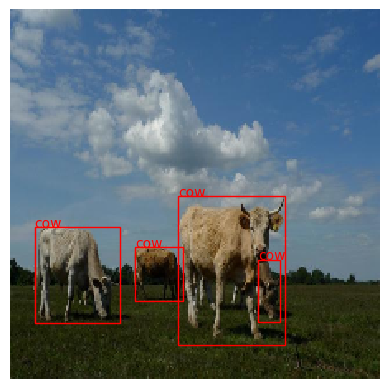

In [ ]:
train_dataset = COCOObjectDetection('partial_dataset.csv', 'COCO-object-detection/train/_annotations.coco.json', 'COCO-object-detection/train/', transform=None)
data, target = train_dataset[5]
class_names = train_dataset.class_names

## --- Plot one sample --- ##
fig, ax = plt.subplots()
ax.imshow(data, cmap='binary', interpolation='nearest')
for box, label in zip(target['boxes'], target['labels']):
  rect = patches.Rectangle((box[0], box[1]), box[2]-box[0],box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
  ax.text(box[0], box[1], class_names[label]['name'], color='red')
  ax.add_patch(rect)
plt.axis('off')
plt.show()

### Train and Evaluate functions

In [ ]:
def train(model, dataloader, optimizer, device):
  '''
    Simple training function.

    Parameters:
    -----------
    model : nn.Module
      Model to be trained.

    dataloader : DataLoader
      Data to train the model.

    optimizer : torch.optim
      Optimizer for backpropagation.

    device : torch.device
      Device to run the training.
  '''

  model.train()
  for inputs, labels in tqdm(dataloader, total=len(dataloader), leave=False, desc='Training'):
    inputs = list(image.to(device) for image in inputs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in labels]

    # --- Insert Code Here --- #

  return None

def evaluate(model, dataloader, device):
  '''
    Simple evaluation function.

    Parameters:
    -----------
    model : nn.Module
      Model to be evaluated.

    dataloader : DataLoader
      Data for evaluation.

    device : torch.device
      Device to run the evaluation.
  '''
  model.eval()
  for inputs, labels in tqdm(dataloader, total=len(dataloader), leave=False, desc='Evaluating'):
    inputs = list(image.to(device) for image in inputs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in labels]

    # --- Insert Code Here --- #

  return None

def save_model(model, best_loss, current_loss):
  '''
    Save the best model weights.
    This function saves the weights locally.
    To prevent data loss, consider adding the Google Drive path in the `torch.save()` function.

    Parameters:
    -----------
    model : nn.Module
      Model to save the weights.

    best_loss : float
      Best loss achieved so far.

    current_loss : float
      Current loss to compare with the best loss.
  '''
  if best_loss == None:
    best_loss = current_loss
    torch.save(model.state_dict(), 'weights.pth')

  elif best_loss > current_loss:
    best_loss = current_loss
    torch.save(model.state_dict(), 'weights.pth')

  else: pass
  return best_loss

def load_model(path, model):
  '''
    Load the model weights.

    Parameters:
    -----------
    path : str
      Path to the .pth file containing the weights.

    model : nn.Module
      Model to load the weights into.
  '''
  model.load_state_dict(torch.load(path))
  return model

def collate_fn(batch):
  return tuple(zip(*batch))

In [ ]:
data_transform = A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
train_dataset = COCOObjectDetection('partial_dataset.csv', 'COCO-object-detection/train/_annotations.coco.json', 'COCO-object-detection/train/', transform=data_transform)
valid_dataset = COCOObjectDetection('_classes_valid.csv',  'COCO-object-detection/valid/_annotations.coco.json', 'COCO-object-detection/valid/', transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

### 4. (1 points) Apply the transfer learning technique by utilizing one of the pre-trained object detection models available in PyTorch as a backbone.

In [ ]:
## TODO: Load a pre-trained convolutional model and fine-tune it on the COCO dataset
# Link: https://pytorch.org/vision/0.8/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

class ObjectDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # --- Insert Code Here --- #
    def forward(self, x):
        # --- Insert Code Here --- #
        return None

model_od = ObjectDetectionModel()

In [ ]:
optimizer     = None  # Choose an appropriate optimizer in https://pytorch.org/docs/stable/optim.html

model.to(device)

best_loss = None

for epoch in range(0, epochs):
  # --- Train Model --- #
  train()

  # --- Evaluate model in N epochs --- #
  if (epoch % evaluate_period) == 0:
    evaluate()

    # --- Save best model weights --- #
    best_loss = save_model(model, best_loss, np.array(history['valid'])[-1].mean())

In [ ]:
## ----- Plot the Train and Valid loss ----- ##
fig, ax = plt.subplots(1, 4, figsize=(20,7))
plt.show()

### Visualize model predictions

In [ ]:
colors = np.random.uniform(0, 255, size=(len(class_names), 3))
model = ObjectDetectionModel()
model.load_model()
model.to(device).eval()

path = 'COCO-object-detection/valid/'
test_images = glob.glob(f"{path}/*.jpg")

# --- Threshold --- #
# Any detection having score below this will be discarded
# Choose between 0 and 1
detection_threshold = None

In [ ]:
def plot_prediction(model, idx, class_names=class_names):
  '''
    Plot one sample

    Parameters
    ----------

    model : nn.Module
      The model to be evaluated.

    idx : int
      The index of the desired image.

    class_names : list
      A list of class names.
  '''

  image_name = test_images[idx].split(os.path.sep)[-1].split('.')[0]
  image = cv2.imread(test_images[idx])
  orig_image = image.copy()
  image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
  image /= 255.0
  image = np.transpose(image, (2, 0, 1)).astype(np.float32)
  image = torch.tensor(image, dtype=torch.float)
  image = torch.unsqueeze(image, 0)

  with torch.no_grad():
    outputs = model(image.to(device))

  outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

  if len(outputs[0]['boxes']) != 0:
    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()

    pred_classes = [class_names[i] for i in outputs[0]['labels'].cpu().numpy()]

    fig, ax = plt.subplots()
    ax.imshow(image.cpu()[0].permute(1,2,0), cmap='binary', interpolation='nearest')
    for j, box in enumerate(draw_boxes):
      class_name = pred_classes[j]['name']
      rect = patches.Rectangle((box[0], box[1]), box[2]-box[0],box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
      ax.text(box[0], box[1], class_name, color='red')
      ax.add_patch(rect)
    plt.axis('off')
    plt.show()

In [ ]:
plot_prediction(model, 50)

 > What are the conclusions? Does the performance improve? (1-2 paragraphs)